# Import all libraries

*cv2*: OpenCV library, which provides tools for computer vision tasks such as image processing, feature detection, and object recognition.

*numpy*: numerical computing, which is commonly used for data manipulation and array operations.

*tensorflow*: Main library of machine learning for building and training deep learning models.

*tensorflow_datasets*: Provides preprocessed datasets for machine learning tasks.

*matplotlib*: Creating visualizations, which may be used for plotting model performance during training.

*import of Dense, Conv2D, MaxPooling2D, Flatten, Dropout, and BatchNormalization*: These are Keras layers from TensorFlow that can be used to build neural networks for various machine learning tasks, more for image classification.

In [58]:
import os
import random
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

## Set hyperparameters, for affect model performance
batch_size(128) - how much images the model will process at a time during each training iteration.
epochs(30) - number of model iterations during training process
Callback functions which used during training process:
* tensorboard_callback - allows you to use TensorBoard, which is a visualization tool provided by TensorFlow, in web UI after execute `tensorboard --logdir=logs/`  http://localhost:6006/
* stop_val_loss - monitors the validation loss and stops the training process if it does not improve for a certain number of epochs(30)
* stop_val_accuracy - monitors the validation accuracy and stops the training process if it does not improve for a certain number of epochs(30)
* lr_schedule_val_loss - monitors the validation loss and reduces the learning rate (lr) when it does not improve for a certain number of epochs(30)

In [2]:
dataset_name = 'cifar10'
image_directory = 'random_images'
batch_size = 128
n_epochs = 30
tensorboard_callback = TensorBoard(log_dir=f'logs/{dataset_name}')
stop_val_loss = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
stop_val_accuracy = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=20)
lr_schedule_val_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

Load the CIFAR-10 dataset, which is a collection of 50,000 training images and 10,000 test images, where each image belongs to one of 10 classes. Link: https://paperswithcode.com/dataset/cifar-10

Load data and split to train and test

In [3]:
_, info = tfds.load(dataset_name, split=['train', 'test'], with_info=True)
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

#### Get parameters of data info:
* class names of dataset CIFAR-10
* number of classes (10)
* shape of images from dataset (32, 32, 3)

In [4]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
input_shape = info.features['image'].shape

print(f"Size of classes: {n_classes}, and their names is: {class_names}")
print(f"Shape of data: {input_shape}")

Size of classes: 10, and their names is: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Shape of data: (32, 32, 3)


## Visualisation of CIFAR-10 data.
Generates a grid of 16 random images with their corresponding labels. Take 16 images from train_data. For each image, its corresponding label is used to set the title.

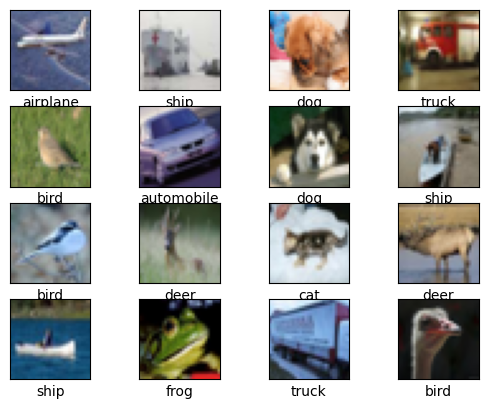

In [5]:
random_nums = [random.randint(0, 50000) for _ in range(16)]

for random, i in zip(random_nums, range(16)):
  plt.subplot(4, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train_data[random], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[random][0]])
plt.show()

#### Normalizing data for model trainings:
Pixel values of the training and test data are rescaled to a range of [0, 1] by dividing them by 255

Flattening the label arrays for ensures that they are in the appropriate format for feeding into the model during training, where the model expects a 1D array of labels.

In [6]:
train_data = train_data / 255
test_data = test_data / 255

train_labels, test_labels = train_labels.flatten(), test_labels.flatten()

#### Data augmentation for better training process:
Used to artificially increase the size of the training dataset by applying random transformations to the existing images. It helps in improving the model's ability to generalize and handle variations in the input data.
Different parameters of ImageDataGenerator:
* rotation_range: Specifies the range of random rotations
* zoom_range: Controls the range of random zooming
* width_shift_range and height_shift_range: Determine the range of random horizontal and vertical shifts

In [7]:
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

train_generator = datagen.flow(train_data, train_labels, batch_size=batch_size)
test_generator = datagen.flow(test_data, test_labels, batch_size=batch_size)

## Convolutional Neural Network model creating

Sequential model that consists of several layers:

* `Conv2D`: Performs 2D convolution on the input data. Takes 32, 64 or 128 number of filters, filter/kernel size (3x3 in this case), the 'same' padding argument ensures that the output feature map has the same spatial dimensions as the input feature map. The activation function used is ReLU(simple non-linear function that takes the maximum between the input value and 0).
* `MaxPooling2D`: Performs max pooling on the output of the previous Conv2D layer. The pool size is (2, 2), which reduces the spatial dimensions of the feature map by half.
* `BatchNormalization`: Normalize the outputs of a previous layer. It works by normalizing the inputs of each mini-batch during training. The purpose is to improve the stability and performance of the model.
* `Dropout`: Randomly drops out a certain proportion of neurons of the input units to prevent overfitting.
* `Flatten`: Flattens the output of the previous layer to a 1D array to prepare it for the fully connected layers.
* `Dense`: Fully connected layer with X units(512 and 1024 in this case) and uses the ReLU activation function. The last Dense layer has number of classes units and uses the softmax activation function to produce class probabilities.

In [8]:
model = Sequential([
    Conv2D(32, 3, padding='same', input_shape=input_shape, activation='relu'),
    BatchNormalization(),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

#### Compile model with specific parameters:
* `Adam optimizer`: combines the benefits of two other popular optimization methods(AdaGrad and RMSProp). It adapts the learning rate dynamically for each parameter, which allows for efficient and effective optimization of the model's weights during training
* `Sparse Categorical Cross-Entropy loss function`: specifically designed for multi-class classification problems(like this) where the labels are integers. It calculates the difference between the predicted probability distribution and the true label distribution. This loss function appropriate because the labels in the dataset are integers representing the class categories.

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

#### Train model (first process)
Used train data and test data like validation, used callbacks that initialized in beginning
Steps per epoch - this specifies the number of steps (batches) to be processed in each epoch. It is typically set as the total number of training samples(50000 and 10000) divided by the batch size(128).

In [10]:
history = model.fit(train_data, train_labels, epochs=n_epochs,
                 validation_data=(test_data, test_labels),
                 callbacks=[tensorboard_callback, lr_schedule_val_loss, stop_val_loss, stop_val_accuracy],
                 batch_size=batch_size,
                 steps_per_epoch=len(train_data) // batch_size,
                 validation_steps=len(test_data) // batch_size)

Epoch 1/30


2023-05-12 12:30:42.024699: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


390/390 [==============================] - 47s 121ms/step - loss: 1.6315 - acc: 0.4267 - val_loss: 2.0960 - val_acc: 0.2753 - lr: 0.0010
Epoch 2/30
390/390 [==============================] - 46s 119ms/step - loss: 1.0756 - acc: 0.6243 - val_loss: 1.0047 - val_acc: 0.6483 - lr: 0.0010
Epoch 3/30
390/390 [==============================] - 47s 121ms/step - loss: 0.8441 - acc: 0.7108 - val_loss: 0.9229 - val_acc: 0.6774 - lr: 0.0010
Epoch 4/30
390/390 [==============================] - 47s 121ms/step - loss: 0.7211 - acc: 0.7556 - val_loss: 0.7040 - val_acc: 0.7634 - lr: 0.0010
Epoch 5/30
390/390 [==============================] - 48s 123ms/step - loss: 0.6195 - acc: 0.7898 - val_loss: 0.6948 - val_acc: 0.7607 - lr: 0.0010
Epoch 6/30
390/390 [==============================] - 48s 123ms/step - loss: 0.5441 - acc: 0.8176 - val_loss: 0.6905 - val_acc: 0.7691 - lr: 0.0010
Epoch 7/30
390/390 [==============================] - 48s 123ms/step - loss: 0.4759 - acc: 0.8376 - val_loss: 0.6727 - val_

#### Train model (second process)
If in first process model can be little bit overfitted then for improve training process, using data augmentation which was done previously and then starts training process

In [11]:
history2 = model.fit(train_generator, epochs=n_epochs,
                 validation_data=test_generator,
                 callbacks=[tensorboard_callback, lr_schedule_val_loss, stop_val_loss, stop_val_accuracy],
                 batch_size=batch_size,
                 steps_per_epoch=len(train_data) // batch_size,
                 validation_steps=len(test_data) // batch_size)

Epoch 1/30
390/390 [==============================] - 53s 134ms/step - loss: 0.6764 - acc: 0.7976 - val_loss: 0.6394 - val_acc: 0.7949 - lr: 2.5000e-04
Epoch 2/30
390/390 [==============================] - 52s 134ms/step - loss: 0.5657 - acc: 0.8175 - val_loss: 0.5901 - val_acc: 0.8034 - lr: 2.5000e-04
Epoch 3/30
390/390 [==============================] - 52s 134ms/step - loss: 0.5226 - acc: 0.8299 - val_loss: 0.5973 - val_acc: 0.8041 - lr: 2.5000e-04
Epoch 4/30
390/390 [==============================] - 49s 126ms/step - loss: 0.5068 - acc: 0.8354 - val_loss: 0.5804 - val_acc: 0.8116 - lr: 2.5000e-04
Epoch 5/30
390/390 [==============================] - 49s 126ms/step - loss: 0.4897 - acc: 0.8396 - val_loss: 0.5475 - val_acc: 0.8186 - lr: 2.5000e-04
Epoch 6/30
390/390 [==============================] - 50s 127ms/step - loss: 0.4807 - acc: 0.8429 - val_loss: 0.5586 - val_acc: 0.8141 - lr: 2.5000e-04
Epoch 7/30
390/390 [==============================] - 49s 126ms/step - loss: 0.4634 - ac

Evaluate model on test data

Performs forward propagation on the test data through the trained model and computes the loss and accuracy metrics.

In [12]:
loss, accuracy = model.evaluate(test_data, test_labels)
print(f"Loss: {loss}, Accuracy: {accuracy}")

313/313 [==============================] - 6s 20ms/step - loss: 0.4122 - acc: 0.8630
Loss: 0.4122438430786133, Accuracy: 0.8629999756813049


## Visualizing the performance of a deep learning CNN model
Visualize data, that have been got after training process of model. Visulization of loss and accuracy line charts. During data watching can be identified some overfitting or underfitting of model


Also for take a look for model training proccesses you can go to terminal execute *tensorboard --logdir=logs/* and go to http://localhost:6006/ , this is user interface of model training with TensorBoard

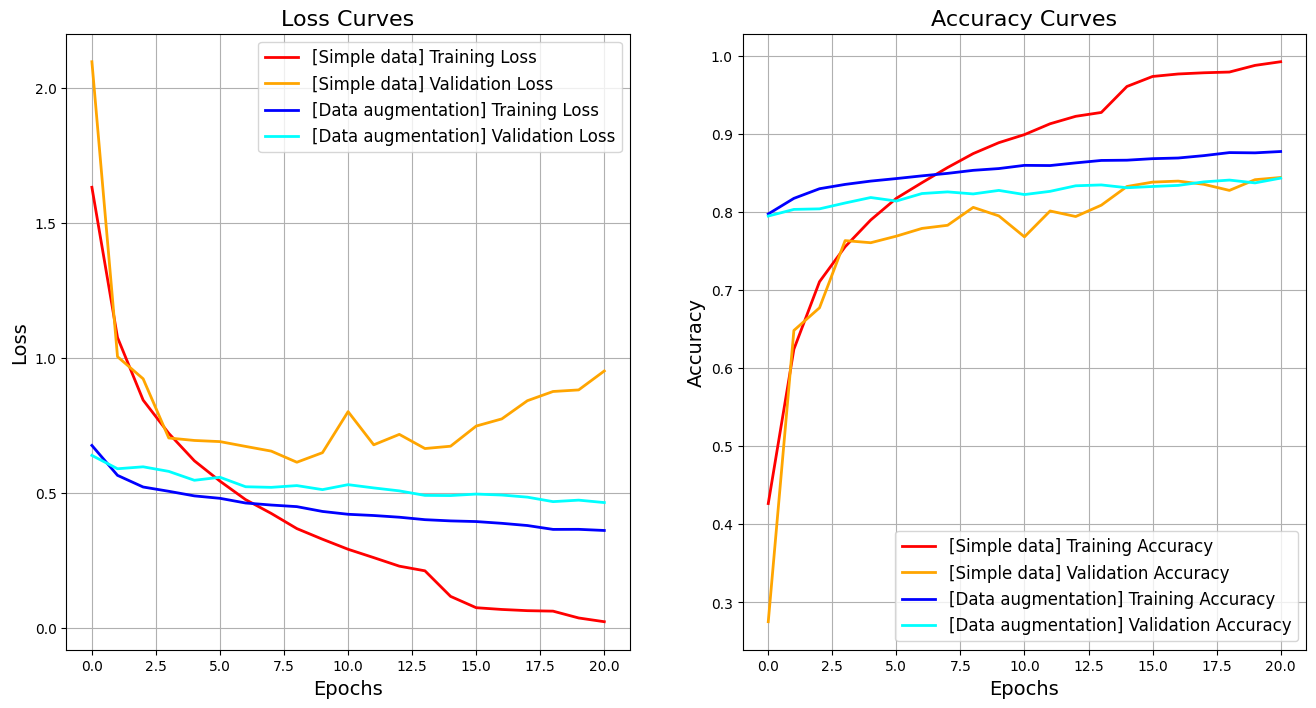

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))

ax1.plot(history.history['loss'], 'red', linewidth=2.0)
ax1.plot(history.history['val_loss'], 'orange', linewidth=2.0)
ax1.plot(history2.history['loss'], 'blue', linewidth=2.0)
ax1.plot(history2.history['val_loss'], 'cyan', linewidth=2.0)
ax1.legend(['[Simple data] Training Loss', '[Simple data] Validation Loss', '[Data augmentation] Training Loss', '[Data augmentation] Validation Loss'], fontsize=12)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('Loss Curves', fontsize=16)
ax1.grid(True)

ax2.plot(history.history['acc'], 'red', linewidth=2.0)
ax2.plot(history.history['val_acc'], 'orange', linewidth=2.0)
ax2.plot(history2.history['acc'], 'blue', linewidth=2.0)
ax2.plot(history2.history['val_acc'], 'cyan', linewidth=2.0)
ax2.legend(['[Simple data] Training Accuracy', '[Simple data] Validation Accuracy', '[Data augmentation] Training Accuracy', '[Data augmentation] Validation Accuracy'], fontsize=12)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.set_title('Accuracy Curves', fontsize=16)
ax2.grid(True)

plt.show()

Visualize the model's predictions on a set of test data

Iterates over the first 25 images in the test data and plots them on each subplot. Set title of true data class and predictioned class

313/313 [==============================] - 6s 19ms/step


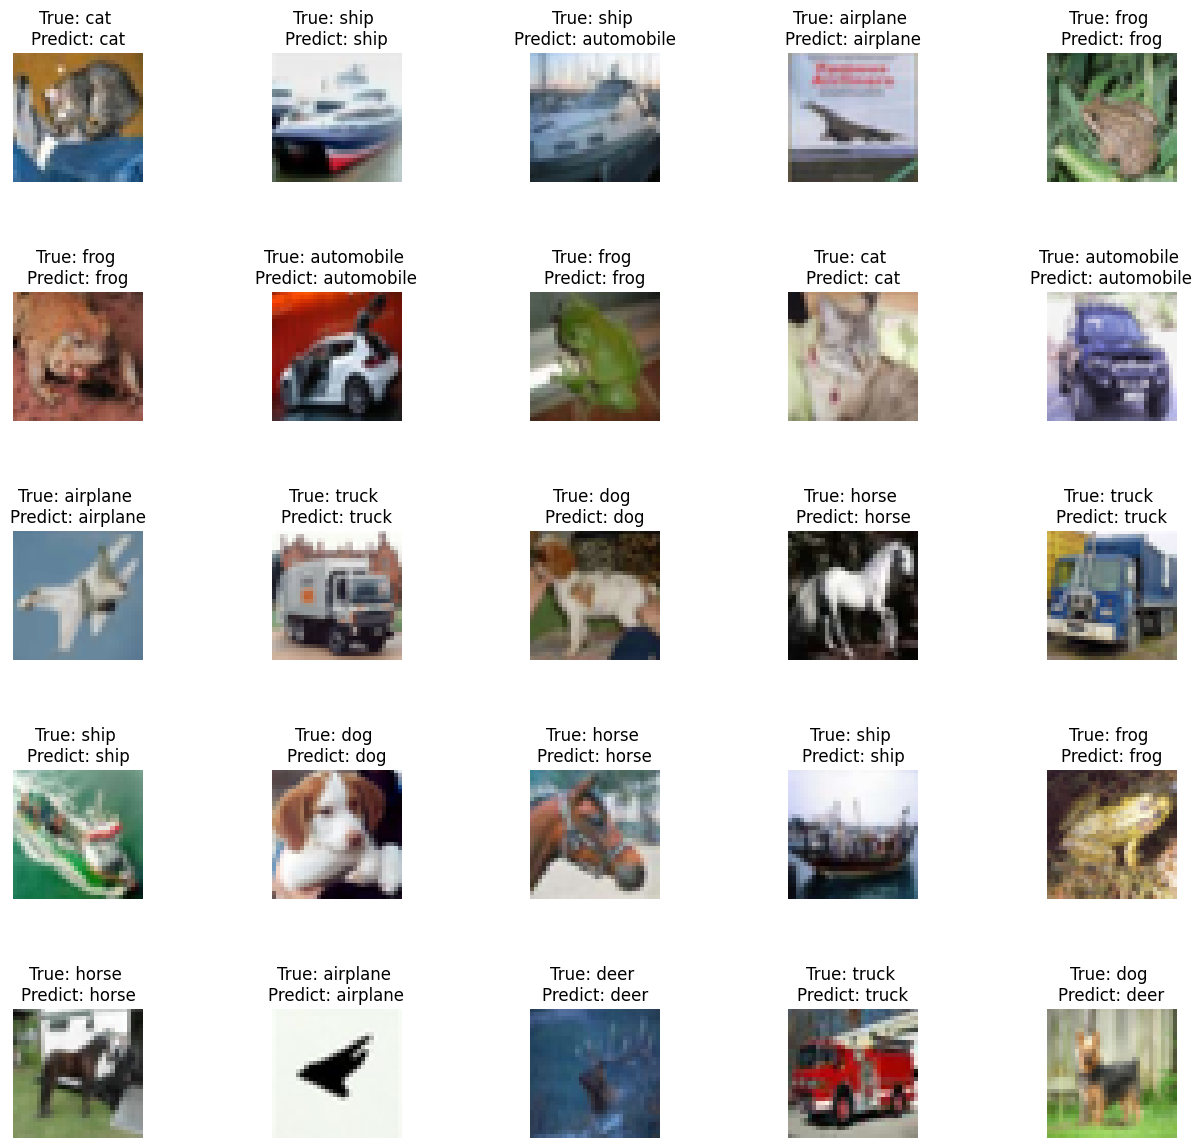

In [14]:
pred = model.predict(test_data)
pred_classes = np.argmax(pred, axis=1)

fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(test_data[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[test_labels[i]], class_names[pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

Method for getting top prediction classes and names on some predictioned image, for visualizing this data on bar chart

In [15]:
def get_top_predictions(prediction):
    top_probs_indices = np.argsort(prediction)[0][::-1][:10]
    top_probs = prediction[0][top_probs_indices]
    top_class_names = [class_names[i] for i in top_probs_indices]
    return top_class_names, top_probs

### Data prediction with random images(data)

Loops over some random images, load it with OpenCV, resizing to 32x32, then make prediction with model and ploting the original image and the corresponding probabilities of each class(with method get_top_predictions)

The resulting figure shows the original image with its predicted class and a bar chart of the probabilities for the top predicted classes.

1/1 [==============================] - 0s 11ms/step


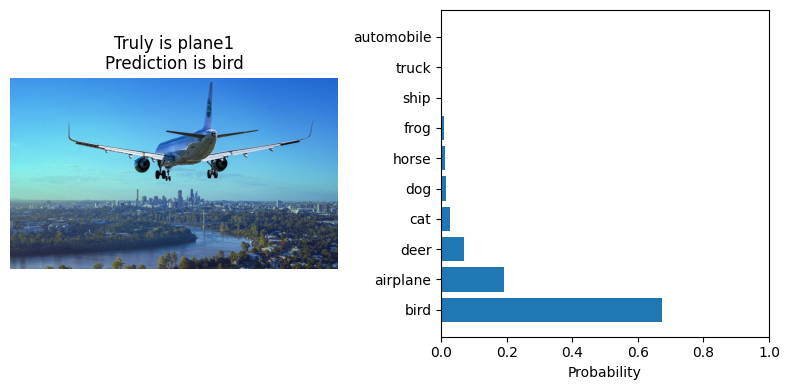

1/1 [==============================] - 0s 10ms/step


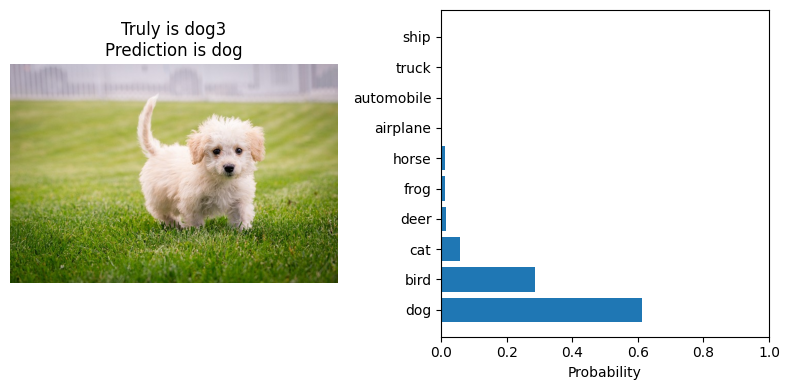

1/1 [==============================] - 0s 10ms/step


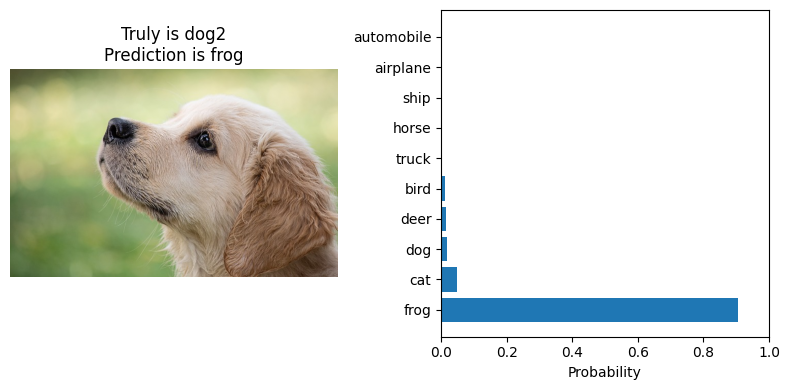

1/1 [==============================] - 0s 10ms/step


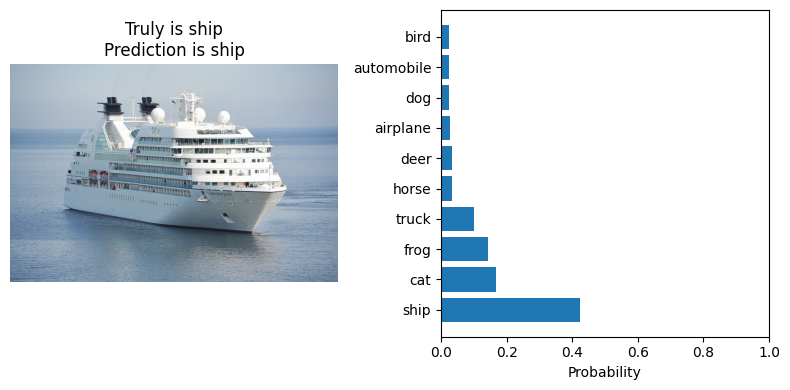

1/1 [==============================] - 0s 10ms/step


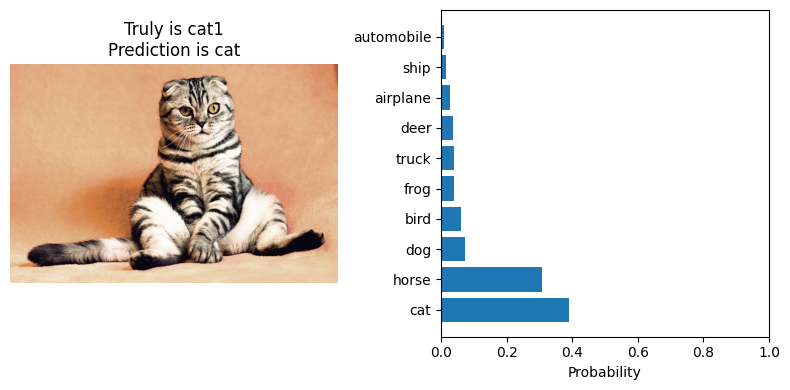

1/1 [==============================] - 0s 11ms/step


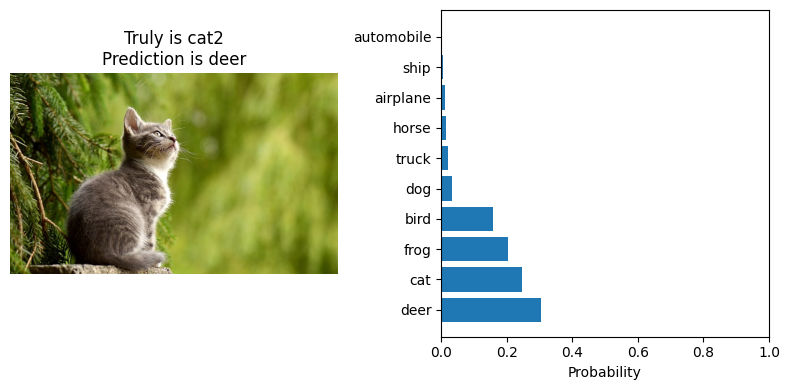

1/1 [==============================] - 0s 11ms/step


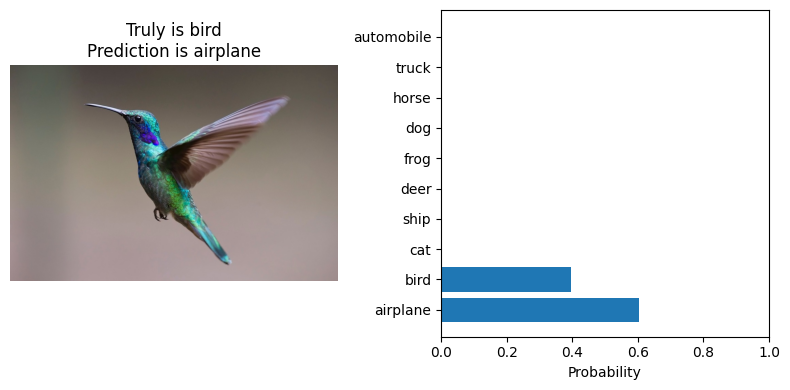

1/1 [==============================] - 0s 10ms/step


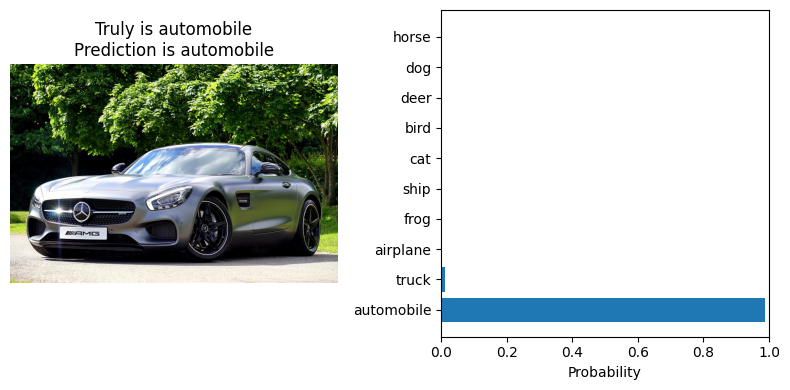

1/1 [==============================] - 0s 9ms/step


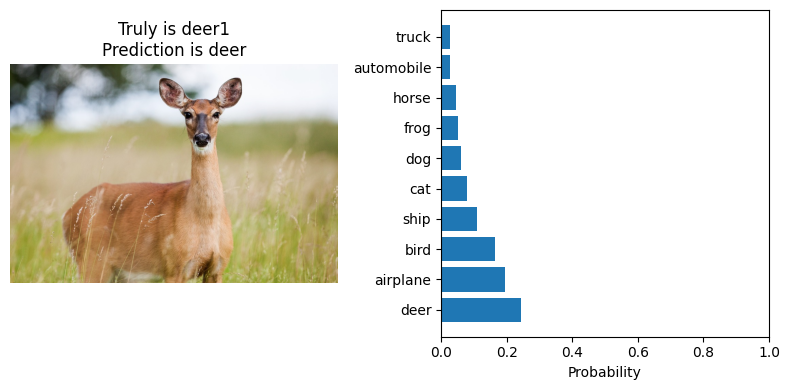

1/1 [==============================] - 0s 10ms/step


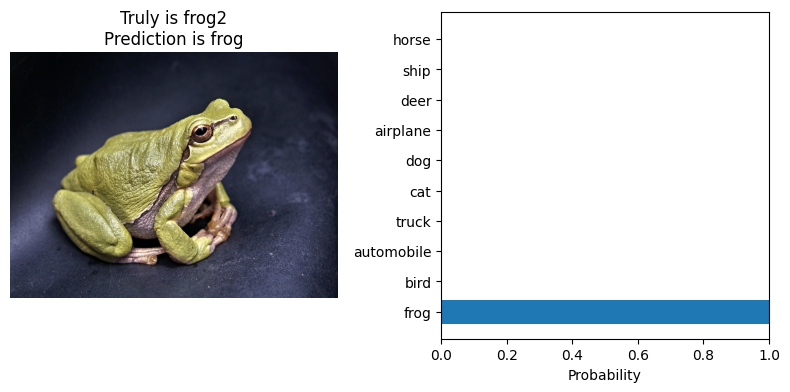

1/1 [==============================] - 0s 11ms/step


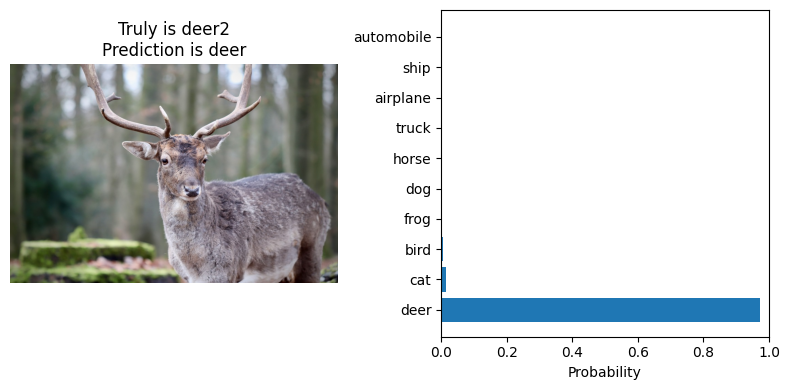

1/1 [==============================] - 0s 11ms/step


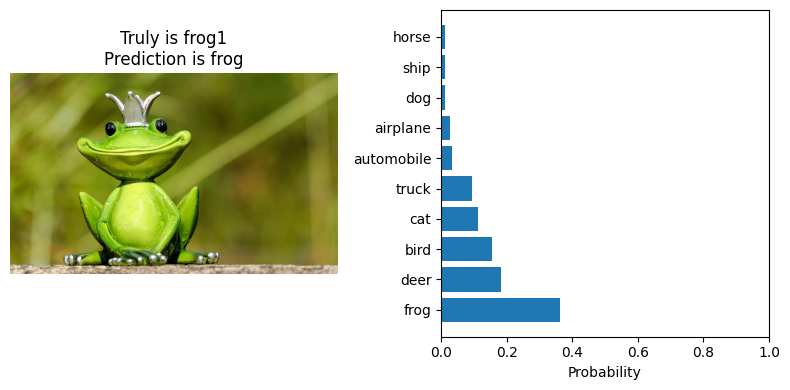

1/1 [==============================] - 0s 11ms/step


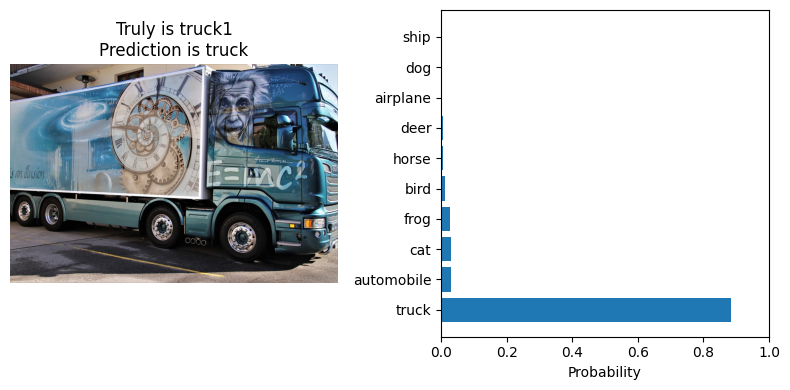

1/1 [==============================] - 0s 9ms/step


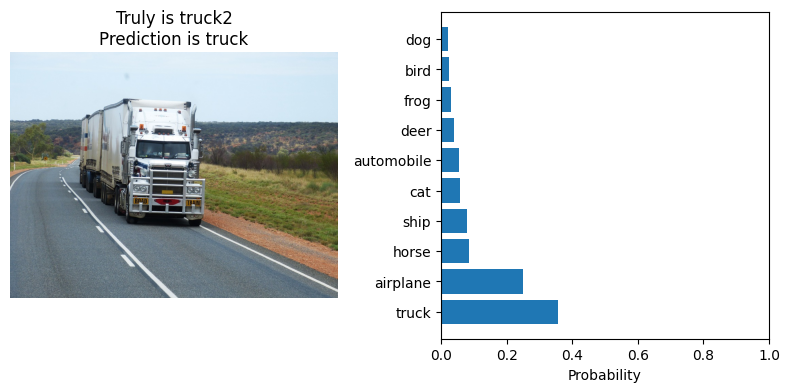

In [61]:
def display_img(img, prediction):
    fig, (img_plt, bar_plt) = plt.subplots(ncols=2, figsize=(8, 4))

    img_plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    img_plt.set_title(f"Truly is {filename.split('.')[0]}\nPrediction is {class_names[np.argmax(prediction)]}")
    img_plt.axis("off")

    top_names, top_predictions = get_top_predictions(prediction)
    bar_plt.barh(top_names, top_predictions)
    bar_plt.set_xlabel("Probability")
    bar_plt.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

for filename in os.listdir(image_directory):
  if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
    plot_img = cv.imread(f"{image_directory}/{filename}")

    img = cv.resize(plot_img, (32, 32))
    img = np.expand_dims(img, axis=0) / 255.0

    prediction = model.predict(img)

    display_img(plot_img, prediction)